In [ ]:
import timeit
from pathlib import Path
import re
import sys
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


TREES_PATH = Path.cwd() / "TRUE_TREES"


In [27]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

# for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
#     scale_tree(str(tree_path), 10, True)


In [33]:
def refresh_sim(tree_file):
    ROOT_SEQUENCE_LENGTH = 500

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=0.03, rate_del=0.03,
                                deletion_extra_edge_length=50,
                                switch_factor=200,
                                seed=111)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim
time_labels = ["tree", "hybrid", "blocktree", "blocklist", "naive"]


In [34]:

time_winners = []
measured_times: list[list[float]] = []





for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path)
    hybrid_time = 1000#timeit.timeit(sim.msa_from_hybrid, number=5)
    blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=5)
    blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=5)
    naive_time = timeit.timeit(sim.msa_from_naive, number=5)

    time_measures = [tree_path, hybrid_time, blocktree_time, blocklist_time, naive_time]
    print(time_measures)
    measured_times.append(time_measures)



[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS20031_60.tree'), 1000, 0.2749031860003015, 0.20503775099859922, 1.3118820640011108]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS20023_31.tree'), 1000, 0.14184053300050437, 0.09760829800143256, 0.37934074900113046]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS20014_65.tree'), 1000, 0.34183598500021617, 0.24623958499796572, 1.681015596997895]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS12029_12.tree'), 1000, 0.046213742996769724, 0.032034805000876077, 0.0992197870000382]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS50016_18.tree'), 1000, 0.13379939000151353, 0.08332358700135956, 0.2953694710013224]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS11007_9.tree'), 1000, 0.059282307000103174, 0.03355602999727125, 0.10052046900091227]
[PosixPath('/h

In [15]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocklist()


5.94 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocktree()

6.23 s ± 67.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_hybrid()

5.84 s ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
times_df = pd.DataFrame(measured_times, columns=time_labels).reset_index()

# times_df.idxmin(axis=1).value_counts()
times_df.loc[(times_df.blocklist - times_df.hybrid).abs().idxmax()].to_list()

[np.int64(58),
 PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS12019_5.tree'),
 np.int64(1000),
 np.float64(0.021077352001157124),
 np.float64(0.012705077999271452),
 np.float64(0.02645640400078264)]

In [36]:
times_df.to_csv("all_methods_comparison_500.csv")

In [ ]:
times_df_100 = pd.read_csv("all_methods_comparison_100.csv", index_col=0)
times_df_100["Root length"] = 100
times_df_500 = pd.read_csv("all_methods_comparison_500.csv", index_col=0)
times_df_500["Root length"] = 500
times_df_1000 = pd.read_csv("all_methods_comparison_1000.csv", index_col=0)
times_df_1000["Root length"] = 1000

times_df = pd.concat([times_df_100, times_df_500, times_df_1000])

list_of_rows = []
for idx, row in times_df.iterrows():
    list_of_rows.append({
        "Root length": row["Root length"],
        "Score type": 'blocklist',
        "Time": row['blocklist']
    })
    list_of_rows.append({
        "Root length": row["Root length"],
        "Score type": 'blocktree',
        "Time": row['blocktree']
    })
    list_of_rows.append({
        "Root length": row["Root length"],
        "Score type": 'naive',
        "Time": row['naive']
    })

df_scores = pd.DataFrame(list_of_rows)

In [58]:
df_scores["Time [ms]"] = df_scores["Time"]*1000

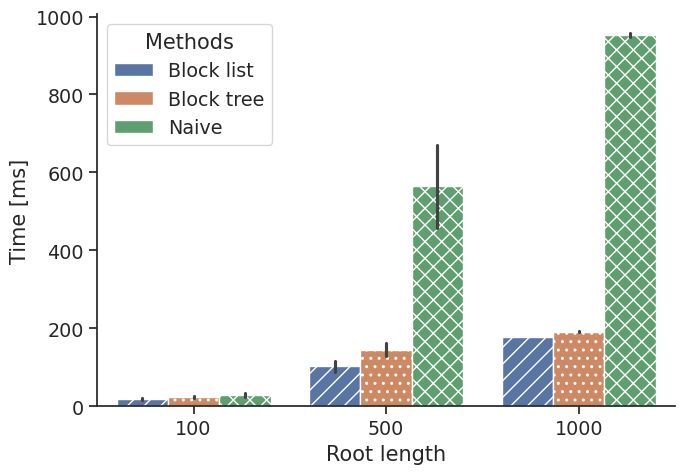

In [93]:
ax = sns.barplot(data=df_scores, x="Root length", y="Time [ms]", hue="Score type")
ax.figure.set_size_inches(7.1, 5)
sns.despine()
hatches = ['//', '//', '//', '..', '..', '..', 'xx', 'xx', 'xx', '//','..', 'xx']
# Loop over the bars
handles, old_labels = ax.get_legend_handles_labels()
new_labels = ['Block list', 'Block tree', 'Naive']  # Your custom labels here
plt.legend(handles, new_labels, title='Methods')

for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

plt.tight_layout()
plt.savefig("assets/orthomam_benchmark_root_length.svg",bbox_inches="tight", dpi=300)
plt.savefig("assets/orthomam_benchmark_root_length.png",bbox_inches="tight", dpi=300)



In [4]:
times_df["naive"] = 1000

In [7]:
times_df.iloc[:,2:].idxmin(axis=1).value_counts()


hybrid       373
blocklist    168
Name: count, dtype: int64

In [ ]:
from _Sailfish import Tree, node


In [26]:
times_df["num_taxa"] = times_df.tree.apply(lambda x: Tree(str(x), True).root.num_leaves)

In [ ]:
times_df

In [101]:
times_df_100.describe()

,index,hybrid,blocktree,blocklist,naive,Root length
count,142.000000,142.0,142.000000,142.000000,142.000000,142.0
mean,70.500000,1000.0,0.023762,0.017500,0.028248,100.0
std,41.135953,0.0,0.019389,0.015672,0.035774,0.0
min,0.000000,1000.0,0.003081,0.002177,0.001355,100.0
25%,35.250000,1000.0,0.009118,0.005353,0.004630,100.0
50%,70.500000,1000.0,0.017880,0.012673,0.012026,100.0
75%,105.750000,1000.0,0.033653,0.025602,0.040659,100.0
max,141.000000,1000.0,0.121061,0.090657,0.194514,100.0


In [98]:
# stats.f_oneway(times_df["naive"], times_df["blocktree"], times_df["blocklist"], times_df["hybrid"])
# stats.f_oneway(times_df_100["blocktree"], times_df_100["blocklist"], times_df_100["naive"])

tuk = stats.tukey_hsd(times_df_100["naive"], times_df_100["blocklist"], times_df_100["blocktree"])
print(tuk)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.011     0.001     0.004     0.018
 (0 - 2)      0.004     0.291    -0.003     0.012
 (1 - 0)     -0.011     0.001    -0.018    -0.004
 (1 - 2)     -0.006     0.092    -0.013     0.001
 (2 - 0)     -0.004     0.291    -0.012     0.003
 (2 - 1)      0.006     0.092    -0.001     0.013



[Text(0, 0, 'Hybrid'), Text(1, 0, 'Naive')]

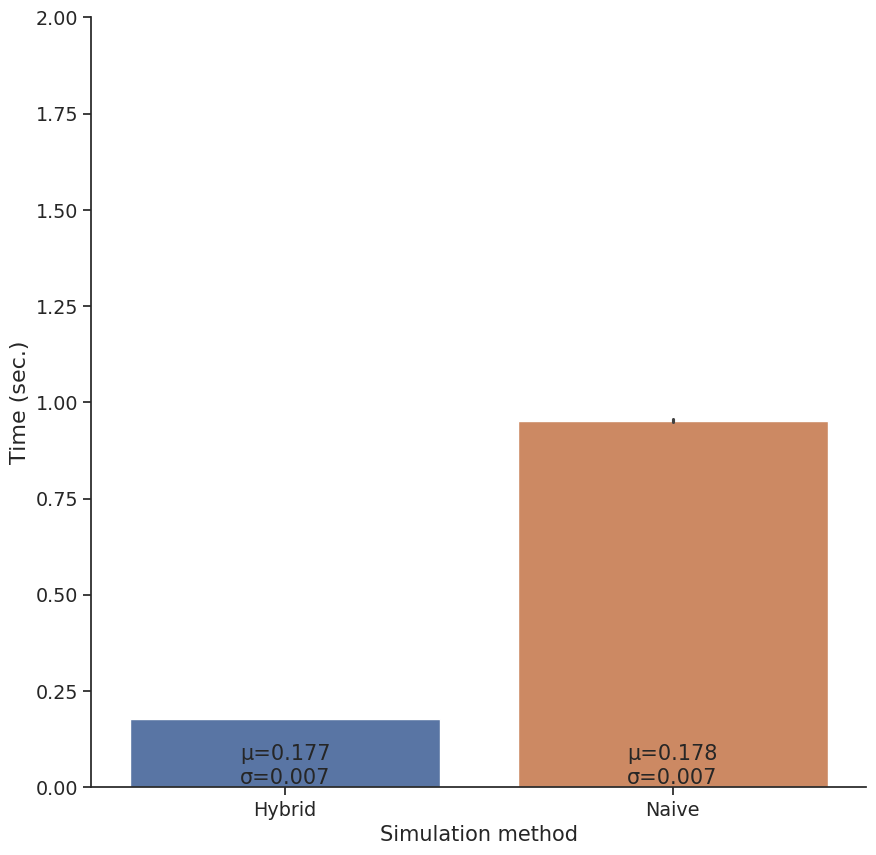

In [ ]:

# ax = times_df.plot.scatter(x="index", y=time_labels[1], label=time_labels[1], figsize=(20, 10), s=40)
sns.set_theme(style="ticks", font_scale=1.25)
ax = sns.barplot(data=times_df.iloc[:,[2,5]], x="Root length")
# ax.set_yscale("log")
ax.set_ylim(0, 2)
ax.set_ylabel("Time (sec.)", size=16)
ax.set_xlabel("Simulation method")
for idx,label in enumerate([time_labels[1], time_labels[3]]):
    mean = times_df[label].mean()
    std = times_df[label].std()
    plt.text(idx, plt.ylim()[0], 
             f'μ={mean:.3f}\nσ={std:.3f}',
             horizontalalignment='center',
             verticalalignment='bottom', size=15)
ax.figure.set_size_inches(10, 10)
sns.despine()

ticks = ax.get_xticks()
ax.set_xticks(ticks)
new_xticklabels = [item.get_text().title() for item in ax.get_xticklabels()]
ax.set_xticklabels(new_xticklabels)

# plt.savefig("assets/orthomam_benchmark.svg",bbox_inches="tight")
# plt.savefig("assets/orthomam_benchmark.png",bbox_inches="tight", dpi=300)

# times_df.plot.box(x="index", y=time_labels[2], ax=ax, label=time_labe
# ls[2], s=40)
# times_df.plot.box(x="index", y=time_labels[3], ax=ax, label=time_labels[3], s=40)
# times_df.plot.box(x="index", y=time_labels[4], ax=ax, label=time_labels[4], s=40)
# ax.set_yscale("log")
# ax.set_ylabel("Time (sec.)", fontsize=25)
# ax.set_xlabel("")

# ax.legend(fontsize=25)
